### 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 불필요한 경고를 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 3.1 MNIST

In [2]:
from sklearn.datasets import fetch_openml

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


그림 저장: some_digit_plot


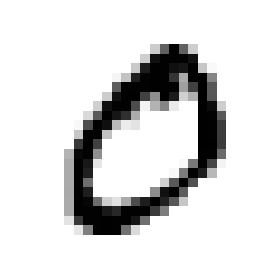

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]    # 맨 첫번째 샘플
some_digit_image = some_digit.reshape(28, 28)    # 특성을 28x28배열로 크기를 바꿈

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [5]:
# 실제 X[0]의 숫자는?
y[0]

0

레이블의 타입은 주로 문자열이다. y를 정수로 변환한다.

In [6]:
y = y.astype(np.uint8)

MNIST는 이미 훈련 세트와 테스트 세트를 나누어 놓았다. (앞쪽 60,000개가 훈련 세트이고 뒤쪽 10,000개가 테스트 세트이다.)  
훈련 세트는 이미 섞여있기하나의 fold에 0부터 9까지의 모든 숫자가 포함되어 있다.
그러니 다시 섞을 필요가 없다.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

0인 숫자와 0이 아닌 숫자로 분류해보자.

In [8]:
# train과 test에서 레이블이(= y값이) '0'인 것들만 따로 정의
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

In [9]:
# 확률적 경사 하강법(=SGD) 분류기 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# 예측
sgd_clf.predict([some_digit])
# 결과는 True로 맞게 예측하였다.

array([ True])

# 3.3 성능 측정
회귀 모델보다 성능 지표가 훨씬 많다.

## 3.3.1 교차 검증을 사용한 정확도 측정

일단 StratifiedKFold로 폴드를 나눈다. 클래스별 비율이 유지되도록 폴드를 만들어준다.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_clf)
    # train
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_0[train_index]
    # test
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_0[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)    # 확률 예측
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9905
0.97925
0.98255


cross_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier모델을 평가해본다.

In [12]:
from sklearn.model_selection import cross_val_score

# cv=3이니까 fold개수는 3개임
# scoring="accuracy"이니까 '정확도'에 대한(= 정확한 예측의 비율에 대한) 값이 나올 것임
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.98015, 0.95615, 0.9706 ])

모든 교차 검증 폴드(= 총 3개의 검증 폴드)에서 정확도가 95% 이상이다.

이제는 모든 이미지를 '0 아님'클래스로 분류하는 더미분류기를 만들어 비교해보자.

In [13]:
from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_0_clf = Never0Classifier()
cross_val_score(never_0_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.70385, 1.     , 1.     ])

실제 이미지의 10%정도만 '숫자 0'이기 때문에 알고리즘은 찍어도 '숫자 0 아님'클래스로 분류할 수 있다.  
**정확도는 분류기의 성능 측정 지표로 선호되지 않는다.**  
특히 **불균형한 데이터셋**을 다룰때 더욱 그렇다.

## 3.3.2 오차 행렬

오차 행렬은 분류기 성능을 평가할 때 아주 좋다.  
클래스 A의 새믈이 클래스 B로 분류된 횟수를 세는 것이다.  
예를 들어, 숫자 5의 이미지를 3으로 분류한 횟수를 알고싶다면 오차 행렬의 5행 3열을 보면 된다.

오차 행렬을 만드려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야한다.  
cross_val_predict()를 사용한다.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

cross_val_predict()은 k-fold 교차검증에서 평가 점수가 아닌 **폴드에서 얻은 예측**을 반환한다.  
이제, 오차 행렬을 만들어보자.(=눈으로 봐보자.)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_0, y_train_pred)

array([[52482,  1595],
       [  267,  5656]], dtype=int64)

<img src="https://media.vlpt.us/images/skyepodium/post/5a1e5052-6094-44a7-af28-ff5b37ed0b75/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202020-04-12%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2012.57.50.png" width="60%">

## 3.3.3 정밀도와 재현율

정밀도: 맞다고 예측한 것들 중에서 실제로도 맞은 비율  
재현율: 실제로 맞은 것들 중에서 맞다고 예측한 비율

In [18]:
from sklearn.metrics import precision_score, recall_score

print("정밀도는", precision_score(y_train_0, y_train_pred))
print("재현율은", recall_score(y_train_0, y_train_pred))

정밀도는 0.78003034064267
재현율은 0.9549214924869154


In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_0, y_train_pred)

0.8586609989373006

정밀도와 재현율이 비슷한 분류기는 F1 점수가 높다.  
하지만 항상 바람직한 것은 아니다.  
상황에 따라서 정밀도가 높은 상황이 좋을 때가 있고, 재현율이 높은 상황이 좋을 때가 있다.  
  
둘을 모두 얻을 수는 없다. 이런 반비례적인 상황을 **정밀도/재현율 트레이드오프**라고 한다.

## 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier는 **결정 함수**로 분류를 결정한다.  
이때, **결정 임계값**에 따라서 정밀도와 재현율이 달라진다.  
  
결정 임계값이 높아지면 정밀도가 높아지고 재현율이 낮아진다.
결정 임계값이 낮아지면 정밀도가 낮아지고 재현율이 높아진다.

In [21]:
# 결정 임계값이 얼마일까?
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([24816.66593936])

In [22]:
# 결정 임계값을 0으로 확 낮추면
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
# 결정 임계값을 60000으로 확 높이면
threshold = 60000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임계값은 어떻게 정할까?  
cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야한다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 한다.

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3,
                             method="decision_function")

그리고 이 점수로 precision_recall_curve()함수를 사용하여 가능한 모든 임계값에 대한 정밀도와 재현율을 계산한다.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

그림 저장: precision_recall_vs_threshold_plot


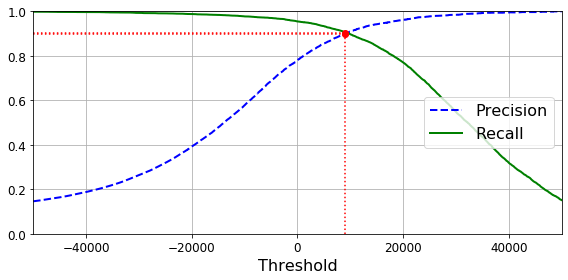

In [27]:
# 정밀도와 재현율을 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

더 좋은 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.  
정밀도가 급격하게 감소하는 곳이 있을 것이다. 이 하강점 직전을 트레이드오프로 선택하는 것이 좋다.  
이런 선택은 프로젝트에 따라 달라진다.

그림 저장: precision_vs_recall_plot


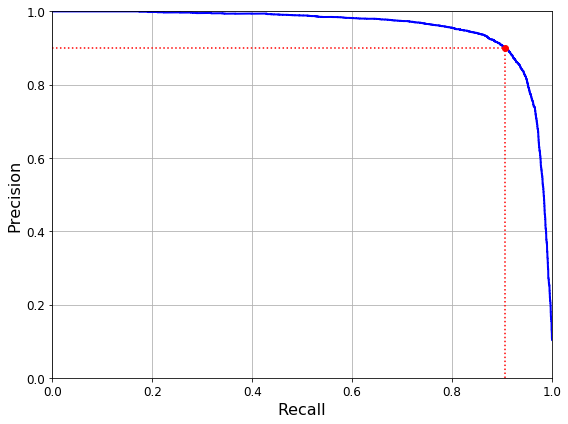

In [28]:
# 재현율에 대한 정밀도 곡선그리기
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


# 재현율이 0.9일때 하강점이 생긴다. 하강점 직전인 곳, 재현율이 80%인 곳을 트레이드 오프로 선택하는 것이 좋음

정밀도 90%를 달성하는 것이 목표라고 하면 다음과 같이 임곗값을 구한다.

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

9075.648564157296

예측을 만드려면 predict()가 아니라 다른 코드를 실행하여 구한다.

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
print("정밀도 90%로 맞췄을 때의 정밀도:", precision_score(y_train_0, y_train_pred_90))
print("정밀도 90%로 맞췄을 때의 재현율:", recall_score(y_train_0, y_train_pred_90))

정밀도 90%로 맞췄을 때의 정밀도: 0.9001007387508395
정밀도 90%로 맞췄을 때의 재현율: 0.9051156508526085


## 3.3.5 ROC 곡선

ROC 곡선은 **거짓 양성 비율(FPR)**에 대한 **진짜 양성 비율(TPR)**의 곡선이다.  
  
FPR은 (1 - 진짜 음성 비율(TNR))이다. TNR은 특이도라고 한다.  
TPR은 재현율과 같다.  
  
즉, ROC곡선은 **민감도(=재현율)에 대한 (1 - 특이도) 그래프**이다.

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

그림 저장: roc_curve_plot


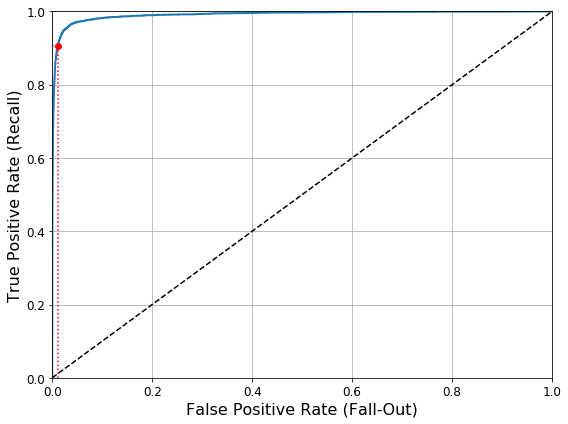

In [34]:
# 그래프로 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

재현율(TPR)이 높을수록 거짓 양성(RPR)이 늘어난다. 즉, 트레이드오프가 있다.  
여기서 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻한다.  
좋은 분류기는 점선에서 멀리 떨어져있어야 한다.

---
**곡선 아래의 면적(AUC)** 을 측정하면 분류기들을 비교할 수 있다.  
완벽한 분류기는 면적이 1, 완전한 랜덤 분류기는 0.5이다.

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_0, y_scores)

0.9910680354987216

RandomForestClassifier를 훈련시켜서 비교해보자.  
RandomForestClassifier에는 decision_function()이 없다. 대신 predict_proba()함수를 사용한다.

In [38]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3,
                                    method="predict_proba")

In [40]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_0, y_scores_forest)

그림 저장: roc_curve_comparison_plot


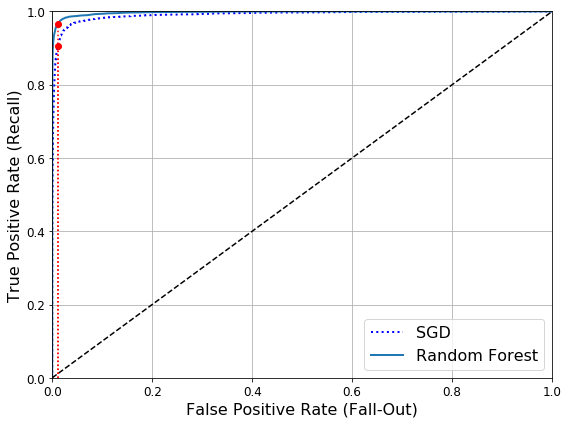

In [41]:
# 두 분류기를 비교해보자
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

RandomForestClassifier의 ROC곡선이 왼쪽 위 모서리에 더 가깝기 때문에 이 분류기가 더 좋다는 것을 알 수 있다.
이때의 면적(AUC)를 구해보자.

In [42]:
roc_auc_score(y_train_0, y_scores_forest)

0.9975104189747056

아까 SGD의 AUC는 0.991 인데 RandomForest의 점수는 0.997로 더 높음을 알 수 있다.

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3)
print("random forest의 정밀도:", precision_score(y_train_0, y_train_pred_forest))
print("random forest의 재현율:", recall_score(y_train_0, y_train_pred_forest))

random forest의 정밀도: 0.9386737576865548
random forest의 재현율: 0.9535708255951376


정밀도와 재현율도 높게 잘 나온다.

# 3.4 다중 분류

In [54]:
y_train = y_train.astype(np.int8)

In [56]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [59]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [60]:
np.unique(X_train)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [62]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

ValueError: The number of classes has to be greater than one; got 1 class